# Mutual inclinations of binary stars and their circumbinary disks

*This notebook explores some concepts that will appear in forthcoming paper by Czekala et al. about circumbinary disks.*

Here's a pretty straightforward question that turns out to have a not-so-straightforward answer. Let's say we have measurements of the inclination of a binary star orbit and its circumbinary disk relative to the sky plane, $i_\star$ and $i_\mathrm{disk}$. And, let's say that these are pretty similar, like $i_\star = 33.42^\circ \pm 0.01^\circ$ and $i_\mathrm{disk} = 33.5^\circ \pm 1.4^\circ$ (as in V4046 Sgr system, [for example](https://ui.adsabs.harvard.edu/#abs/2012ApJ...759..119R/abstract)). How misaligned are the circumbinary disk and the plane of the binary orbit, i.e., what's their mutual inclination? You might say the fact that

$$
|i_\mathrm{disk} - i_\star| = |33.5^\circ - 33.42^\circ| < 0.1^\circ
$$

means that these planes are pretty much coplanar. However, that's not the full story because $i$ just tells us the inclination of each orbit relative to the sky plane and we need to know the position angle of the ascending node $\Omega$ to actually visualize the orbit in 3D space. Given both measurements of $i$ and $\Omega$ for both the binary star orbit and its circumbinary disk, we can calculate the mutual inclination $\theta$ (sometimes called $\Delta I$) between the two planes as

$$
\cos (\theta) = \cos i_\mathrm{disk} \cos i_\star + \sin i_\mathrm{disk} \sin i_\star \cos(\Omega_\mathrm{disk} - \Omega_\star).
$$

For a growing sample of binary stars with double-lined radial velocity solutions and circumbinary protoplanetary disks resolved by ALMA, we generally have precise constraints on $i_\mathrm{disk}$, $\Omega_\mathrm{disk}$, and $i_\star$, but no constraint on $\Omega_\star$. Therefore, we are unable to directly solve for $\theta$. 

To make this problem concrete, let's consider the circumbinary system V4046 Sgr, which, in addition to the inclinations quoted, also has $\Omega_\mathrm{disk} = 256^\circ \pm 1.0^\circ$. Our goal is to use the measurements of these three parameters to determine the posterior probability distribution of the mutual inclination $\theta$. Our ultimate goal is to compare the distribution of the mutual inclinations of these circumbinary disks to the distribution of mutual inclinations for the Kepler circumbinary planets in order to learn something about how planet formation proceeds around binary stars. The *Kepler* planets have all been [measured to have](https://ui.adsabs.harvard.edu//#abs/2015ARA&A..53..409W/abstract) $\theta < 5^\circ$, although there is concern that *Kepler* would not detect planets with larger mutual inclinations.

First, we'll walk through the example of V4046 Sgr using a typical Bayesian inference setup making what seem like reasonable assumptions, and end up with a counter-intuitive result. Then, we'll introduce a hierarchical model that includes a parameterization of the mutual inclination distribution. To test this, we'll make two samples of fake data, one with intrinsically low mutual inclinations and one with isotropically randomly oriented orbits. Finally, we'll use our model to see if we correctly infer the input distributions. 

## Inferring $\theta$ for one disk

Let's write down a posterior distribution for $\theta$ given the information about the V4046 Sgr system that we just listed. To do this we'll come up with a joint posterior distribution for the 4 binary and disk parameters $i_\mathrm{disk}, \Omega_\mathrm{disk}, i_\star, \Omega_\star$ and then use samples from this posterior and the mutual inclination formula to calculate the posterior distribution of $\theta$.

We'll need to write down a likelihood function and a set of priors. We'll start with the priors and make an assumption that both the disk and the binary orbit can be randomly oriented in 3D space. This means that the unit angular momentum vector of the orbit has uniform probability of pointing anywhere on the unit sphere. This translates into a prior probability distribution on the orbital parameters of

$$
p(i, \Omega) = \frac{\sin i}{2},
$$

Which is a uniform distribution in position angle ($\Omega$) from [0,360] degrees and a $\sin i$ taper on the inclination. This is a consequence of the fact that there's less surface area at higher latitudes on the unit sphere.

Let's denote the measured parameters of V4046 Sgr as $\hat{i_\mathrm{disk}}, \hat{\Omega_\mathrm{disk}}, \hat{i_\star}$. For most systems, these parameters are highly constrained with Gaussian uncertainties and with minimum covariances between parameters. Therefore, we will use a multivariate normal as our likelihood function

$$ p( \hat{i_\mathrm{disk}}, \hat{\Omega_\mathrm{disk}}, \hat{i_\star} | i_\mathrm{disk}, \Omega_\mathrm{disk}, i_\star, \Omega_\star ) = {\cal N}( \hat{i_\mathrm{disk}}, \hat{\Omega_\mathrm{disk}}, \hat{i_\star} | i_\mathrm{disk}, \Omega_\mathrm{disk}, i_\star, \Omega_\star, \boldsymbol{\Sigma})$$

e.g., this is just a multivariate Gaussian centered on $\hat{i_\mathrm{disk}}, \hat{\Omega_\mathrm{disk}}, \hat{i_\star}$, and the shape of the Gaussian is described by the covariance matrix $\boldsymbol{\Sigma}$, which has no off-diagonal terms. There are more conditional parameters to this likelihood (like $\Omega_\star$), but since we don't have data on this parameter, there are only three dimensions to the Gaussian likelihood function.


We can combine both of these to write down an (unnormalized) posterior probability distribution 

$$ p(i_\mathrm{disk}, \Omega_\mathrm{disk}, i_\star, \Omega_\star | \hat{i_\mathrm{disk}}, \hat{\Omega_\mathrm{disk}}, \hat{i_\star})  = p( \hat{i_\mathrm{disk}}, \hat{\Omega_\mathrm{disk}}, \hat{i_\star} | i_\mathrm{disk}, \Omega_\mathrm{disk}, i_\star, \Omega_\star ) \frac{\sin i_\mathrm{disk} \sin i_\star}{4}
$$

We will use MCMC to sample this posterior distribution and then use the mutual inclination formula to convert these samples of $i_\mathrm{disk}, \Omega_\mathrm{disk}, i_\star, \Omega_\star$ to a posterior on $\theta$.

Let's start by importing some packages that will help us solve this problem, such as the normal ones like numpy and matplotlib, but also PyMC3 and Theano (its modeling language). We could just as easily do this using packages more familiar to astronomers (like emcee), but to solve the hierarchical problem we'll want to take advantage of some of the more powerful features of probabilistic programming languages like PyMC3.

In [1]:
# code here
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 20
import matplotlib.pyplot as plt

import numpy as np
import theano.tensor as tt
import pymc3 as pm

deg = np.pi/180.0

In [2]:
# The basic parameters of V4046 Sgr from Rosenfeld et al. 2012

# When sampling distributions it helps to make sensible (well-behaved) choices of parameterizations. 
# For this reason we are using the cosine of inclination and all angles are in radians.
# cos (i_disk), Omega_disk, cos(i_star)
data = np.array([np.cos(33.5 * deg), 256.0 * deg, np.cos(33.42 * deg)])
    
# We've also converted the inclination uncertainties to cos() via propagation of error 
# sigma_cos_i = sin(i) * sigma_i (where sigma_i is in radians)
sigma = np.array([ np.sin(33.5 * deg) * 1.4 * deg, 1.0 * deg, np.sin(33.42 * deg) * 0.01 * deg])

In [3]:
# This is how we set up a model in PyMC3. Basically, we use a special `model` context and then 
# declare random variables as being drawn from some distribution.

# instantiate a PyMC3 model class 
with pm.Model() as model:
    
    # These are the priors on i_disk, Omega_disk, i_star, Omega_star
    # sin(i) prior means a uniform prior on cos(i)
    cos_i_disk = pm.Uniform("cosIdisk", lower=-1.0, upper=1.0)
    Omega_disk = pm.Uniform("OmegaDisk", lower=0.0, upper=2*np.pi) # radians
     
    cos_i_star = pm.Uniform("cosIstar", lower=-1.0, upper=1.0)
    Omega_star = pm.Uniform("OmegaStar", lower=0.0, upper=2*np.pi) # radians
     
    # These are some helpful intermediate quantities for determining mutual inclination
    # to go from cos(i) -> sin(i), do 
    # Note that since we are in a PyMC3 context, we use the theano methods of sqrt (not np.sqrt, for example)
    sin_i_disk = tt.sqrt(1.0 - cos_i_disk**2)
    sin_i_star = tt.sqrt(1.0 - cos_i_star**2)
        
    # store cos theta as a deterministic byproduct to keep track of it as we go
    cos_theta = pm.Deterministic("cosTheta", cos_i_disk * cos_i_star + \
                               sin_i_disk * sin_i_star * tt.cos(Omega_disk - Omega_star))

    # assemble a vector to compare to the observations
    mu = [cos_i_disk, Omega_disk, cos_i_star]
    
    # Finally, we define the likelihood by conditioning on the observations 
    obs = pm.Normal("obs", mu=mu, sd=sigma, observed=data)    

In [4]:
# sample the posterior using whatever MCMC algorithm PyMC3 deems best
with model:
    trace = pm.sample(draws=1000, tune=2000, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [OmegaStar, cosIstar, OmegaDisk, cosIdisk]
Sampling 2 chains: 100%|██████████| 6000/6000 [00:12<00:00, 499.76draws/s] 


In [5]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
cosIdisk,0.833984,0.013224,0.000240,0.807371,0.858999,2393.643703,0.999777
OmegaDisk,4.468537,0.017312,0.000274,4.435032,4.501964,3576.466544,0.999786
cosIstar,0.834656,0.000098,0.000002,0.834475,0.834867,3823.209465,0.999534
OmegaStar,3.126730,1.751603,0.033132,0.246175,6.108989,2757.611272,0.999500
cosTheta,0.699187,0.218473,0.003593,0.391652,1.000000,3270.852581,0.999520


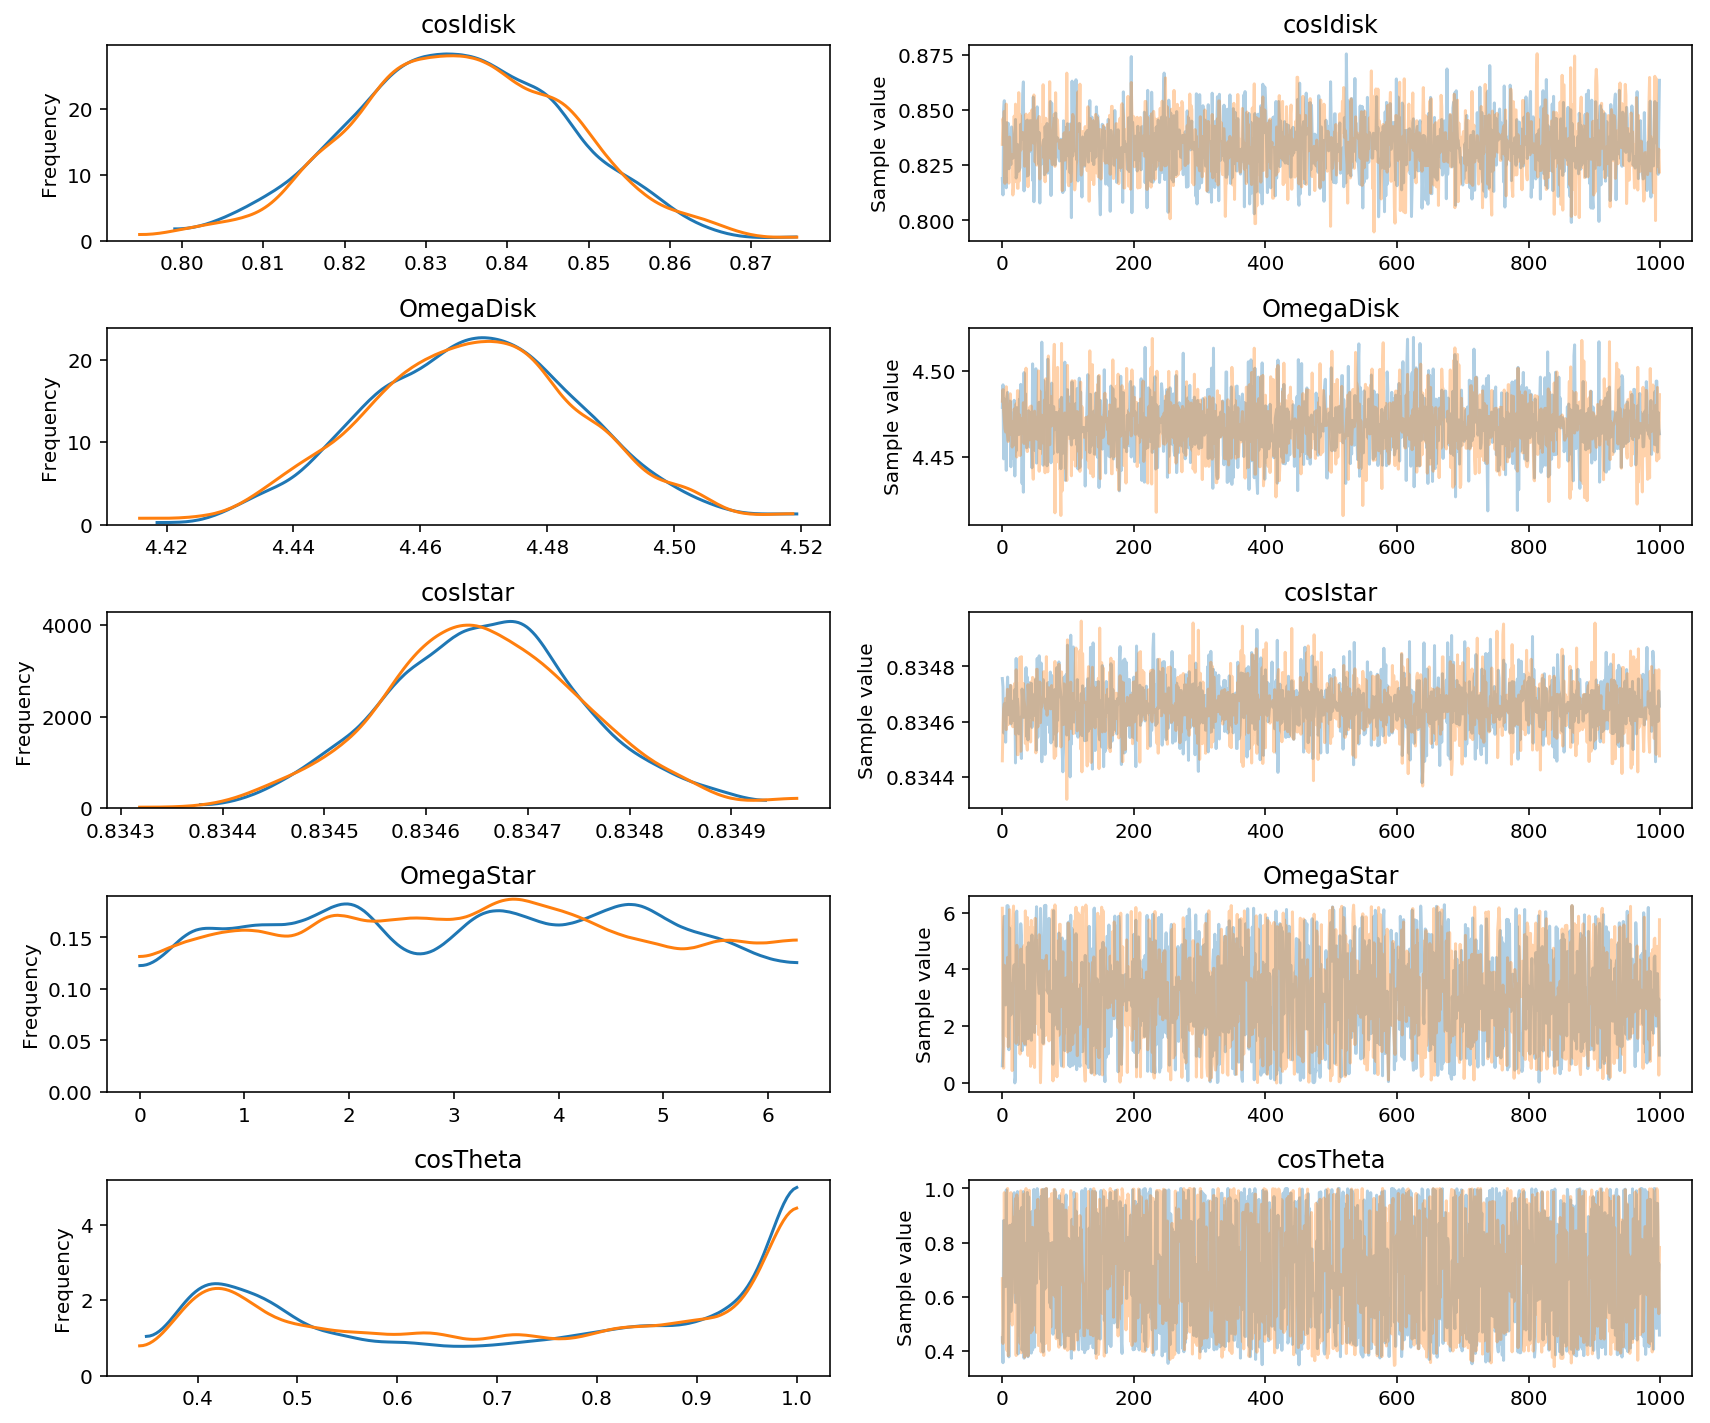

In [7]:
# visualize the output
pm.traceplot(trace);

From these diagnostics, we have confidence that the MCMC algorithm converged to the target distribution. Now, let's convert these samples back to the actual angles in degrees so we have a better chance of understanding what the mutual inclination posterior looks like.

In [8]:
samples = pm.trace_to_dataframe(trace, varnames=["cosIdisk", "OmegaDisk", "cosIstar", "OmegaStar", "cosTheta"])

# create a new dataframe with columns in the right units
asamples = samples.copy()
asamples.rename(index=str, columns={"cosIdisk":"iDisk", "cosIstar":"iStar", "cosTheta":"theta"}, inplace=True);

# a small function to convert from cos(parameter) to parameter in degrees
icos2deg = lambda x: np.arccos(x)/deg

asamples["iDisk"] = asamples["iDisk"].apply(icos2deg)
asamples["OmegaDisk"] = asamples["OmegaDisk"] / deg
asamples["iStar"] = asamples["iStar"].apply(icos2deg)
asamples["OmegaStar"] = asamples["OmegaStar"] / deg
asamples["theta"] = asamples["theta"].apply(icos2deg)

In [9]:
# use DFM's corner package to plot up the distribution
import corner  

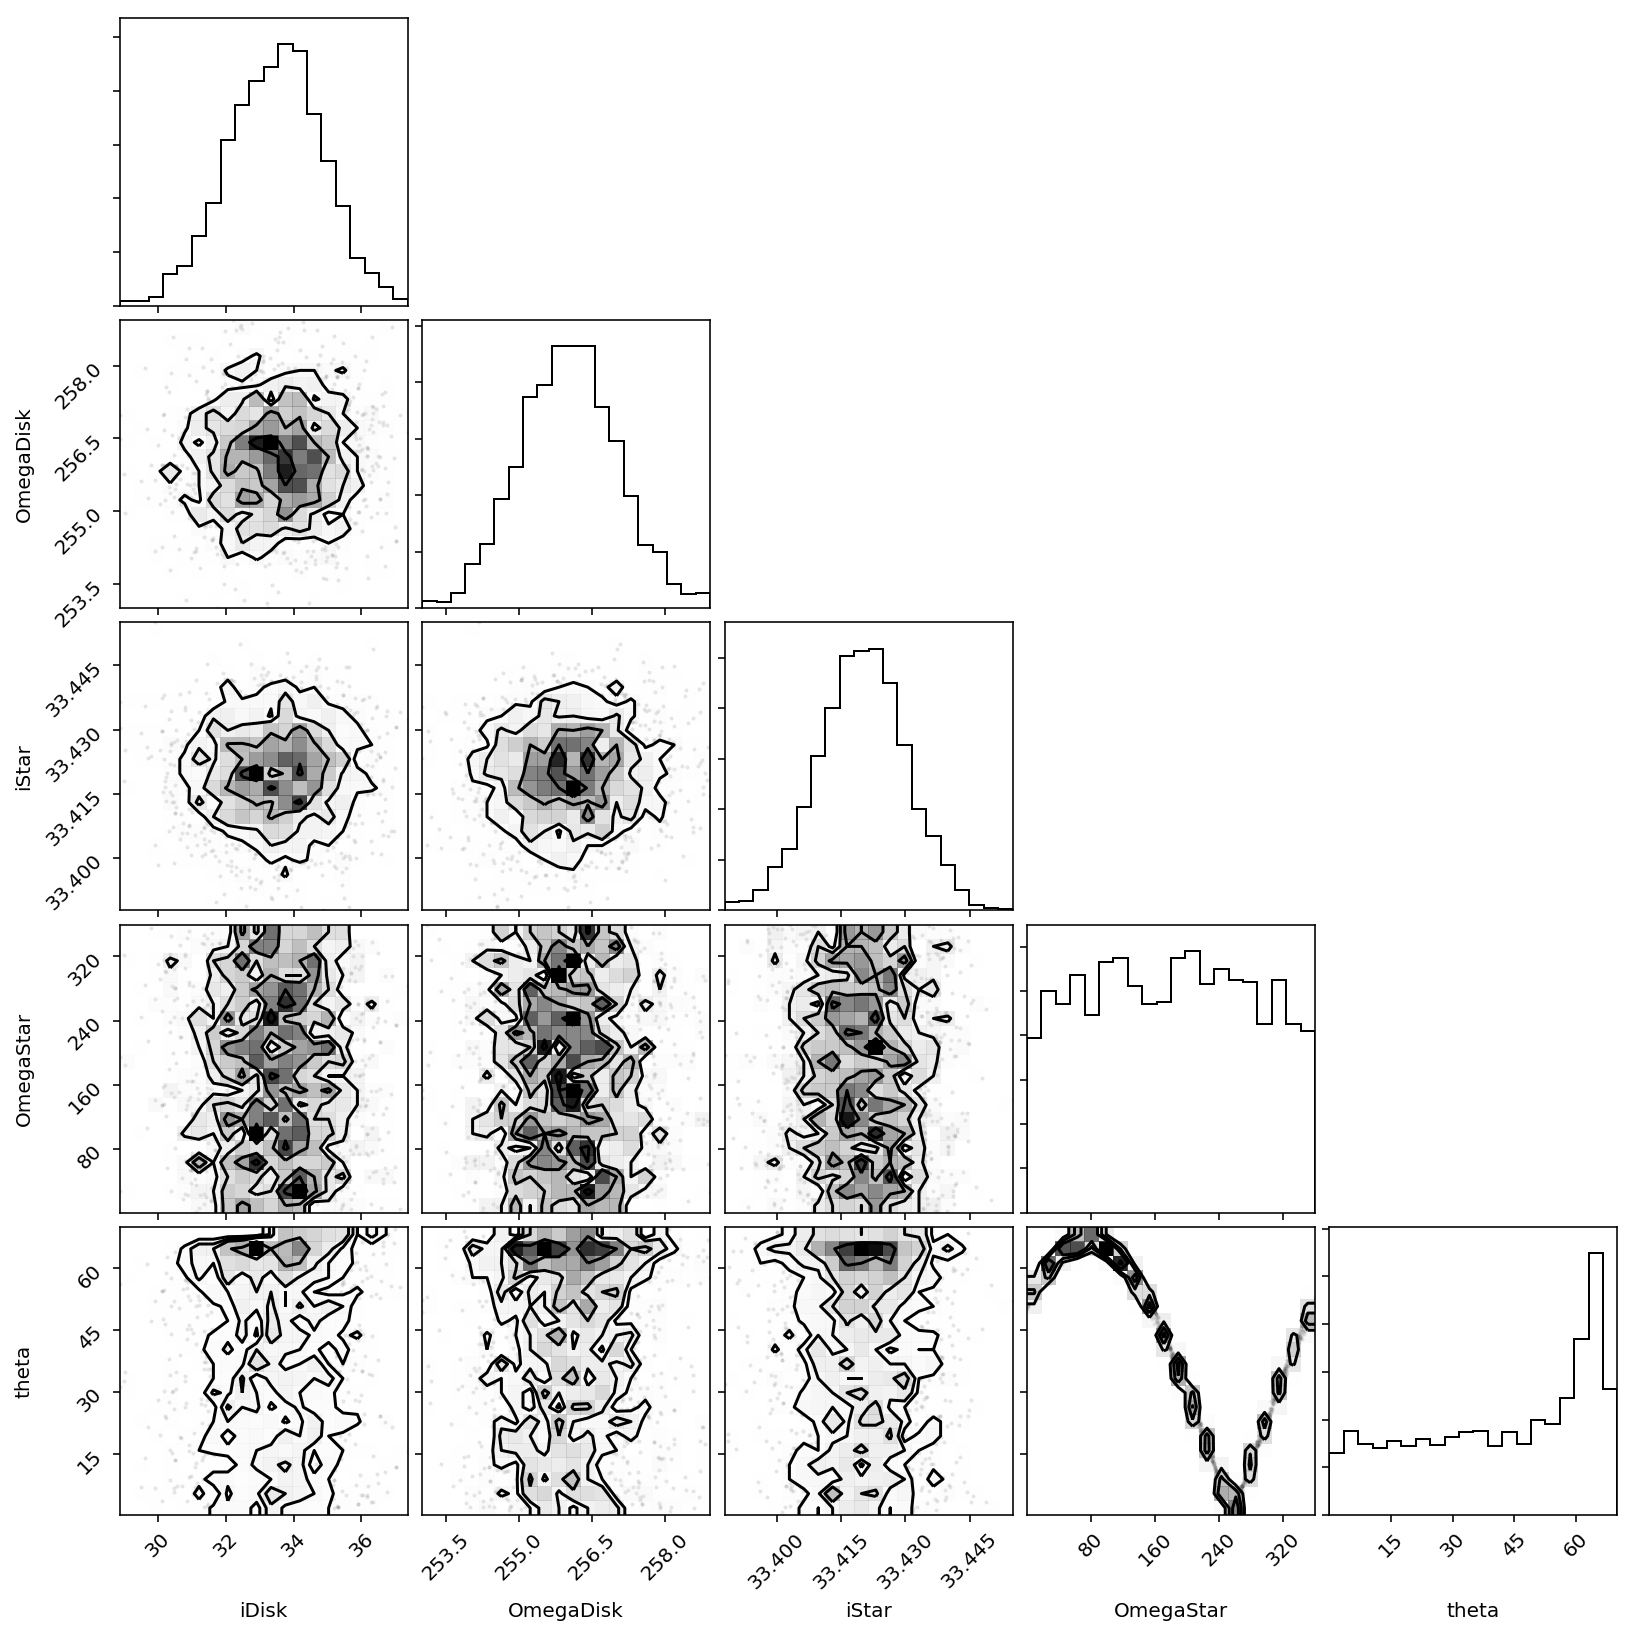

In [10]:
corner.corner(asamples);

This 5-parameter histogram gives a great view on what's going on with this model (all quantities are in degrees here). The first three parameters are the ones we have measurements for, and so we can see that the marginal posteriors (the topmost plot of each column) of these parameters match the constraints from the data. We had no data to constrain $\Omega_\star$, and so this posterior looks just like the uniform prior that we put on it. The fifth parameter, $\theta$, is a deterministic calculation from the previous four parameters. Interestingly, it's broad and spans from 0 degrees up until about 70 degrees.

To see why this behavior arises, consider the 4th panel in the very bottom row, which is the joint posterior of $\theta$ and $\Omega_\star$. Because $\Omega_\star$ is unconstrained, as we clock this parameter around [0, 360] degrees we can generate quite significant $\theta$. In retrospect, this all makes a lot of sense. If we think of a unit sphere with the observer above the north pole and we have measured $i_\mathrm{disk} \approx i_\star$, all we can say is that the unit angular moment vectors of the disk and the binary point near the same latitude. 

To really drive this point home, let's say you are in Montreal, Canada, at latitude 45.50 deg N, and longitude 75.57 deg W. Your friend sees you post something about this to your social media feed and he get's in touch and says "Hey, *I'm* at 45.46 deg N, why don't you come over and we'll grab a coffee?" Without knowing anything about your friend's longitude (i.e., a uniform prior), he could *just as likely* be in Milan, Italy (which is also at 45.50 N) as he is on the otherside of metropolitan Montreal. To find out how far of a drive away he is, you need to know his longitude.

The "just as likely" part is key here, and explains why the posterior on mutual inclination looks the way it does. Without knowing anything about latitute (or $\Omega_\star$), for most latitudes there's usually plenty of space available on the globe to be situated a far drive away. The situation gets better as you head very far north or south, since maximum possible driving distance decreases with proximity to the poles. If both you and your friend knew you were at 89.90 degrees N latitude, for example, regardless of what longitudes you were at, your friend would at most be a 14 mile drive away from you. In that case, it's probably not a bad idea to hit your friend up for that hot coffee, because after all, it's frosty outside.

In the contex of our circumbinary disk measurements, this conclusion about the $\theta$ posterior is sobering but also feels somewhat unsatisfactory. After the initial excitement of measuring $i_\mathrm{disk} \approx i_\star$ and thinking that these planes must be nearly coplanar, we're reminded at the end of the day that if we're being honest, we can't really report anything other than a maximum limit on their misaligment.

While this is absolutely true for a single disk, the reason why this feels unsatisfactory is highlighted by the following thought experiment. Say we had a sample of 10 disks, and we measured $i_\mathrm{disk} \approx i_\star$ for all of them. We would suspect that there is some sort of alignment in 3D space going on, because if there wasn't, we would have already seen at least a few disks with $i_\mathrm{disk} \ne i_\star$ in this sample. So if our goal is to infer the mutual inclination distribution for all circumbinary disks, then our one-by-one approach is missing something captured by our intuition for the properties of the sample. One way to put math to our intuition is to couch the inference of the mutual inclination distribution of all the circumbinary systems in a hierarchical Bayesian model.

# Hierarchical modeling 

One way to think about hierarchical Bayesian modeling is that we're going to repeat the exercise in the first part of the notebook for every disk in our sample, simultaneously. And, instead of just assuming that the prior on the orientation of the binary relative to the disk is isotropic, we'll parameterize this prior with some flexible function and see if we can actually infer the form of this prior as well. 

The first step is to assume some functional form for our mutual inclination distribution $p({\theta})$, which describes the frequency of systems with that $\theta$. Basically, we want something that easily take on a wide variety of forms and has as few parameters as possible. Common choices used in literature include the [Beta](https://docs.pymc.io/api/distributions/continuous.html#pymc3.distributions.continuous.Beta), the [Weibull](https://docs.pymc.io/api/distributions/continuous.html#pymc3.distributions.continuous.Weibull), and the [Gamma](https://docs.pymc.io/api/distributions/continuous.html#pymc3.distributions.continuous.Gamma). We have the power to define our own custom function within [PyMC3/Theano](https://docs.pymc.io/Probability_Distributions.html).

Since we're dealing with vectors in spherical geometry, a desirable quality of this mutual inclination distribution is that (regardless of whether mutual inclinations are in general low or high) it obeys

$$
\lim_{\theta \to 0^\circ} p(\theta) = 0
$$

To understand why, think about pointing a telescope at a target at $(\alpha, \delta)$. There will always be some (small) pointing error, so we actually point at $(\alpha + \epsilon_\alpha, \delta + \epsilon_\delta)$. This means that there will *always* be some *positive* radial pointing error $\epsilon_\rho = \sqrt{\epsilon_\alpha^2 + \epsilon_\delta^2}$, and so there should be 0 probability that we point *exactly* at $(\alpha, \delta)$. For the same reason, the criterion also applies for pointing in the exact opposite direction

$$
\lim_{\theta \to 180^\circ} p(\theta) = 0
$$

## Parameterizing the mutual inclination distribution 

A common go-to functional choice among hierarchical Bayesians is the $\beta$ distribution, since it's very flexible and has only two parameters, $\alpha$ and $\beta$. The fact that convention states one of the parameters of the $\beta$ distribution is also named $\beta$ is super confusing, so in what follows we'll use $p_\beta$ to refer to the distribution in equations. The probability density function (PDF) of the $\beta$ function is 

$$
p_\beta(x |\, \alpha, \beta) = \frac{x^{\alpha - 1}(1 - x)^{\beta - 1}}{B(\alpha, \beta)}
$$
where
$$
B(\alpha, \beta) = \frac{\Gamma(\alpha) \Gamma(\beta)}{\Gamma(\alpha + \beta)}
$$

and $p_\beta$ is defined over the range $[0,1]$. From the PDF, we see that if we enforce a prior that $\alpha > 1$ and $\beta > 1$, then this will give us the behavior that the probability goes to zero at the edges of the domain. As an example, here is a range of $p_\beta$ for a range of $\alpha$ and $\beta$ values. 



In [11]:
import itertools

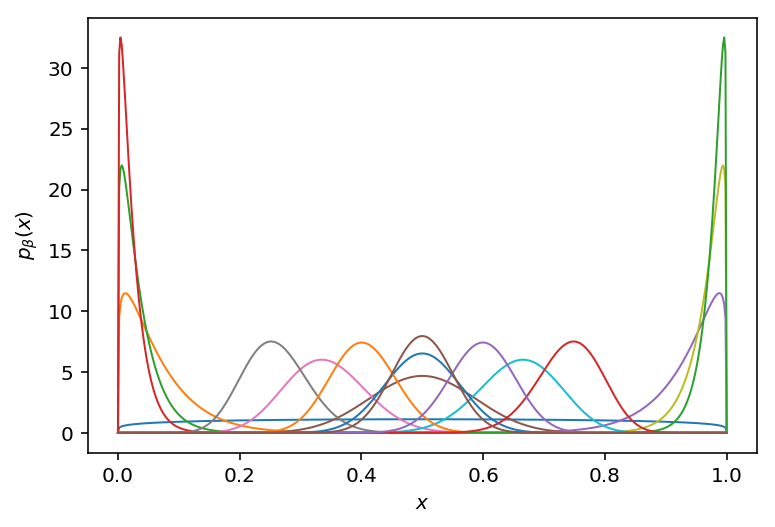

In [13]:
alphas = np.linspace(1.2, 50.0, num=4)
betas = np.linspace(1.2, 50.0, num=4)

xs = np.linspace(0, 1, num=500) # inputs 

fig, ax = plt.subplots(nrows=1)

for alpha,beta in itertools.product(alphas, betas): # plot all combinations
    y = pm.Beta.dist(alpha=alpha, beta=beta) # query the PyMC3 implementation
    ys = np.exp(np.array([y.logp(x).eval() for x in xs]))
    ax.plot(xs, ys, lw=1.0)
    
ax.set_xlabel(r"$x$");
ax.set_ylabel(r"$p_\beta(x)$");

Now that we've established that the $\beta$ distribution is a promising parameterization of our mutual inclination distribution, we need to interface it to our actual problem. This involves transforming the variable $\theta$ into something that fits the range $[0, 1]$. The true domain of $\theta$ is [0,180] degrees. We can use the variable $\cos\theta$, which ranges from $[-1, 1]$, and then multiply it by $1/2$ to shoehorn it into the right domain. This gives us an intermediat mutual inclination variable

$$
x = 0.5 (1 - \cos \theta)
$$

where $x = 0$ is completely aligned and $x = 1$ is anti-aligned (the negative sign in front of $\cos$ is to keep the intuitive behavior that low $x$ corresponds to low $\theta$). To go from $x$ to $\theta$, we have 

$$
\cos \theta = 1 - 2 x 
$$


Through this change of parameters we also need to conserve probability

$$
p(x)\,\mathrm{d}x = p(\theta)\,\mathrm{d} \theta
$$

where

$$
\mathrm{d}x = -0.5 \sin(\theta)\,\mathrm{d}\theta
$$

To put this all together, we'll say that the modified mutual inclination $x$ for any particular system is drawn from the distribution of mutual inclinations 

$$
x \sim p_\beta(\alpha, \beta)
$$

When we're doing a fit of the orbital parameters of an individual system $k$, this means we'll have prior of

$$
p_k(x_k| \alpha, \beta) = p_\beta(x_k | \alpha, \beta)
$$

In the space of $\theta$, this prior is 

$$
p_k(\theta) = p_k(x_k| \alpha, \beta) \frac{\mathrm{d}x}{\mathrm{d}\theta} = 0.5 p_\beta(0.5(1 - \cos \theta) | \alpha, \beta) \sin(\theta)
$$

## Fitting a system hierarchically 


Let's revisit the posterior distribution for the mutual inclination of a single system $k$ with this new prior on $p(\theta)$ in mind. This prior says that the angle of one plane *relative to the other* is supposed to have a particular value. Since we measure both $i_\mathrm{disk}$ and $\Omega_\mathrm{disk}$, we'll use the disk as a reference point and keep the isotropic prior on its orientation 

$$
p_k(i_\mathrm{disk}, \Omega_\mathrm{disk}) = 0.5 \sin(i_\mathrm{disk})
$$

Now, rather than assuming geometric priors on $p(i, \Omega)$ for the disk and binary, we want to use the information from the $\theta$ prior we just specified. The mutual inclination prior serves the following purpose. Given the location of the disk orbit (via values of $i_\mathrm{disk}$ and $\Omega_\mathrm{disk}$, or some other parameterization), it tells us which values of $\theta$ are more likely than others. 
As you might have suspected all along, because we don't know anything about $\Omega_\star$, the specific value we measure for $\Omega_\mathrm{disk}$ is actually irrelevant to the problem. The main quantity of interest for the mutual inclination formula is the difference between the two $\Delta \Omega = \Omega_\mathrm{disk} - \Omega_\star$. So we set $\Omega_\mathrm{disk} = 0$ as a reference point and use the variable $\Delta \Omega$.

To set up the relationships about to come, it will be helpful to introduce a new coordinate system in the disk frame and specify the rotation matrices needed to convert from the disk frame to the observer frame.





### Rotating between the disk and observer frames

We'll start by considering a coordinate system in the frame of the circumbinary disk, such that the $z$ axis is aligned with the unit angular momentum vector of the disk. In this frame, we can specify the location of the binary unit angular momentum vector on the unit sphere by two angles, the mutual inclination, which is also the polar angle $\theta$, and an azimuthal angle, $\phi$. Here is a sketch of the angles we have defined so far.

<img src="fig.png" alt="Drawing" style="width: 600px;"/>



In Cartesian coordinates in the disk frame, the binary unit vector points to

$$
\left [ \begin{array}{c}
x\\
y\\
z\\
\end{array} \right]
=
\left [ \begin{array}{c}
\sin \theta \cos \phi \\
\sin \theta \sin \phi \\
\cos \theta \\
\end{array} \right]
$$

To go from $\theta$ and $\phi$ in the disk frame ($x,y,z$) to $i_\star$ and $\Omega_\star$ in the observer frame ($X, Y, Z$), we need two rotations. The rotation matrices we'll need for this problem are

$$
  \boldsymbol{P}_x(\xi) = \left [
  \begin{array}{ccc}
    1 & 0 & 0 \\
    0 & \cos \xi & - \sin \xi \\
    0 & \sin \xi & \cos \xi \\
    \end{array}\right]
$$

$$
  \boldsymbol{P}_z (\xi) = \left [
  \begin{array}{ccc}
    \cos \xi & - \sin \xi & 0\\
    \sin \xi & \cos \xi & 0 \\
    0 & 0 & 1 \\
    \end{array}\right].
$$

These rotation matrices result in a *clockwise* rotation of the axes, as defined using the right hand rule. This means when we look down the $z$ axis, for a positive angle $\xi$, it would be as if the $x$ and $y$ axes rotated clockwise.

Let $X$, $Y$, and $Z$ be the coordinates of the observer frame, with the observer looking down the $Z$ axis, $X$ representing north and $Y$ representing east. In our convention, we assume $\Omega$ is positive measured in the counter-clockwise direction, i.e., north towards east. 


It's easier (for me) to first consider the transformation of going from the observer frame to the disk frame. To do this, first we'll rotate about the $Z$ axis by an amount $\Omega_\mathrm{disk}$ (in the negative, counter-clockwise direction). Then, around this new $x$ axis, we'll rotate by an amount $i_\mathrm{disk}$.

$$
\left [ \begin{array}{c}
x\\
y\\
z\\
\end{array} \right]
=
\boldsymbol{P}_x(i_\mathrm{disk}) \boldsymbol{P}_z(- \Omega_\mathrm{disk}) 
\left [ \begin{array}{c}
X\\
Y\\
Z\\
\end{array} \right]
$$

Then, the transformation from the disk frame into the observer frame is just the inverse. The inverse rotation matrices are just the transposes of the forward rotation matrices, so we have

$$
\left [ \begin{array}{c}
X\\
Y\\
Z\\
\end{array} \right]
=
\boldsymbol{P}_z^{-1}(- \Omega_\mathrm{disk}) \boldsymbol{P}_x^{-1}(i_\mathrm{disk}) 
\left [ \begin{array}{c}
x\\
y\\
z\\
\end{array} \right]
$$

To convert $X$, $Y$, and $Z$ into $i_\star$ and $\Omega_\star$, we'll just use trigonometry. All along we've been using the unit sphere, so $1 = \sqrt{X^2 + Y^2 + Z^2}$ and 

$$
i_\star = \cos^{-1} (Z)
$$

$$
\Omega_\star = \tan^{-1}(Y / X) - \pi/2
$$

### Hierarchical model

Ok, now that we've defined $\theta$ and $\phi$ in the disk frame and specified how to convert these back to the observer frame, let's get back to the hierarchical model. A mutual inclination prior $p(\theta)$ specifies the angle between the disk and binary unit angular momentum vectors, but not the azimuthal orientation of them ($\phi$). So, given some mutual inclination $\theta$, the prior on the position of the binary unit vector on the unit sphere looks like a ring centered on the disk unit vector. This means that in the frame of the disk, the prior on the binary unit vector location is separable, 

$$
p(\theta, \phi) = p(\theta) p(\phi)
$$
 
where $p(\phi)$ is uniform from $[0, 2\pi]$. 

At any point along the ring $\phi | \theta$ we can use the relationship $i_\star = \cos^{-1} Z$ to calculate $i_\star$. Writing this all out, we have a functional relationship

$$
\cos i_\star = f_\star(\cos i_\mathrm{disk}, \theta, \phi) =  -\sqrt{1 - \cos^2 i_\mathrm{disk}} \sin \theta \sin \phi + \cos i_\mathrm{disk} \cos \theta
$$

As we mentioned, because we don't have any constraint on $\Delta \Omega$, we don't have any constraint on $\phi$ either (note that $\Delta \Omega \ne \phi$, but these quantites are related through the rotation matrices in a one-to-one manner once $\cos i_\mathrm{disk}$, $\theta$ and $\cos i_\star$ are specified). 

The first option is to leave $\phi$ as a parameter in the model and sample it in much the same way as we did $\Omega_\star$ in the first example, and that is what we will do in this notebook for demonstration purposes. However, because this adds an extra parameter for each disk in our sample, it's not ideal. A second option is to analytically marginalize over $\phi$ and sample in the reduced parameter space. We'll cover the math and implementation for that in a second notebook, located [here](https://github.com/iancze/hierarchical-mutual-inclinations/blob/master/MarginalPrior.ipynb).

**The final distribution for any disk**

# Generating fake data

Great, we have a road map of how we'd like to go about inferring the mutual inclination distribution in a hierarchical fashion. To unit test our hierarchical model, let's create a few fake data tests to see how well we can recover *known* distributions. We'll try out this formalism on at least two different fake datasets generated with different underlying mutual inclination distributions. 

1. A distribution with random isotropic binary orbits
2. A distribution with low mutual inclinations

To keep the comparison consistent, we'll first randomly draw disk parameters and then keep these fixed for both comparisons. 

In [3]:
np.random.seed(42)
N_systems = 10

# let's get a sample of uniformly oriented disks in 3D space 
# Generate randomly oriented momentum vector on the sky.
U = np.random.uniform(size=N_systems)
V = np.random.uniform(size=N_systems)

# spherical coordinates for angular momentum vector, uniformly distributed.
i_disks = np.arccos(2 * V - 1.0) / deg # polar angle
Omega_disks = 2 * np.pi * U / deg # azimuth

## Random isotropic binary orbits

Generating the first distribution of binary orbits is pretty easy, these will be drawn from the same isotropic distributions as generated the disks. 

In [4]:
# draw new random numbers 
U = np.random.uniform(size=N_systems)
V = np.random.uniform(size=N_systems)

# spherical coordinates for angular momentum vector, uniformly distributed.
i_star_isos = np.arccos(2 * V - 1.0) / deg # polar angle
Omega_star_isos = 2 * np.pi * U / deg # azimuth

Let's calculate the actual mutual inclinations and assemble this into a table for easy viewing. Remember that the mutual inclination formula is

$$
\cos (\theta) = \cos i_\mathrm{disk} \cos i_\star + \sin i_\mathrm{disk} \sin i_\star \cos(\Omega_\mathrm{disk} - \Omega_\star).
$$

In [5]:
def calc_theta(i_disk, Omega_disk, i_star, Omega_star):
    '''
    Calculate the mutual inclination between two planes. Assumes all inputs in degrees.
    '''
    
    cos_theta = np.cos(i_disk * deg) * np.cos(i_star * deg) + \
        np.sin(i_disk * deg) * np.sin(i_star * deg) * np.cos((Omega_disk - Omega_star) * deg)
    theta = np.arccos(cos_theta)/deg
    
    return theta

In [6]:
theta_isos = calc_theta(i_disks, Omega_disks, i_star_isos, Omega_star_isos)

In [7]:
# create tables of all of these things as datasets
from astropy.table import Table

# compute the mutual inclination of these too, and add it as a column
iso_sample = Table([i_disks, Omega_disks, i_star_isos, Omega_star_isos, theta_isos], \
                   names=["i_disk", "Omega_disk", "i_star", "Omega_star", "theta"])

In [8]:
iso_sample

i_disk,Omega_disk,i_star,Omega_star,theta
float64,float64,float64,float64,float64
163.50227502309326,134.8344427850505,77.5792099187767,220.2670421000566,100.61160001808521
19.978699877320064,342.2571503075698,131.21997640876015,50.21778983473506,121.52418225622642
48.32647488671633,263.51781905210584,150.44665083985393,105.17207347267853,157.04332940963047
125.12216966480769,215.51705431093316,26.133385763746237,131.890263585729,118.45811433182247
129.52018838155797,56.16671055927715,21.367275077809136,164.18519431813294,132.80827038537694
129.28594162348503,56.158027321032954,51.91755783309811,282.6633461014849,144.08366758190044
113.04883202952833,20.910100380551807,113.00257276038445,71.88256157700951,46.65828234481898
87.16196151047119,311.82341247897665,143.57702442255513,185.1243978289002,113.21810541327116
97.82280854361962,216.4014042275552,68.37895413381068,213.2692447903353,29.60381899378459


As we can see, most of these have pretty different $i_\mathrm{disk}$ and $i_\star$, though there is one system that has $i_\mathrm{disk} \approx i_\star = 113^\circ$. However, because $\Omega_\mathrm{disk} \ne \Omega_\star$, it does indeed have a rather large mutual inclination of $47^\circ$. Your results may vary depending on your random seed.

To generate the second distribution with low mutual inclinations requires some of the aforementioned rotations in spherical coordinates.

## Low mutual inclinations

The mutual inclination $\theta$ only specifies the magnitude of the displacement of the binary vector from the disk vector, not the direction. 

To generate binary orbits with low mutual inclinations we'll take the following approach. In the disk coordinate system

1. Randomly generate a polar angle $\theta$ from the specified distribution of mutual inclinations $p_\beta(\theta |\, \alpha, \beta)$
2. Randomly generate an azimuthal angle $\phi$ from [0, 360] degrees. 

Together $\theta$, $\phi$ specify the binary unit vector in the disk coordinate system. Then, using the known orientation of the disk frame (from $i_\mathrm{disk}$ and $\Omega_\mathrm{disk}$) rotate the binary unit vector to the observer frame and record $i_\star$ and $\Omega_\star$.

For the fake data, we'll assume some mutual inclination distribution that is a Gaussian with $\sigma = 2^\circ$ and mean $5^\circ$, tapered by a $\sin(\theta)$ profile. So, we have 

$$
p(\theta) \propto \sin(\theta) \exp \left ( - \frac{(\theta - 5^\circ)^2}{2 (2^\circ)^2} \right)
$$

This looks like the following

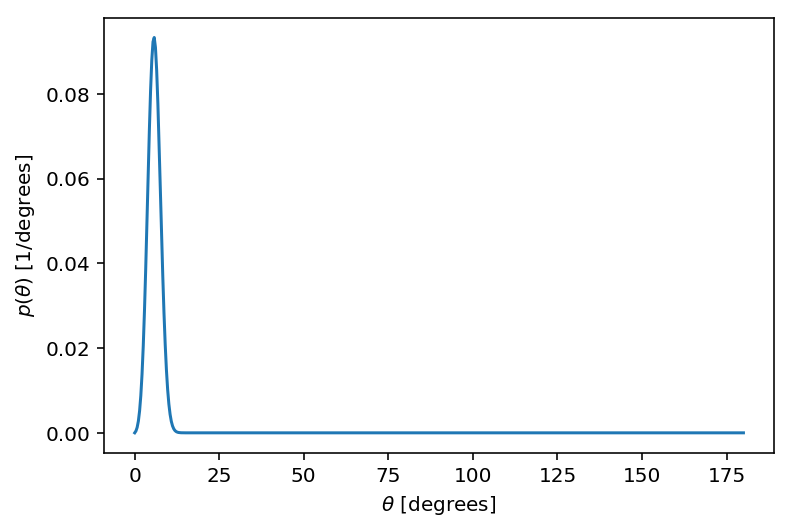

In [9]:
def input_prob(theta):
    '''
    theta is in degrees.
    '''
    return np.sin(theta * deg) * np.exp(-0.5 * (theta - 5.0)**2 / (2**2))

dis = np.linspace(0, 180.0, num=500)
p_is = input_prob(dis)

plt.plot(dis, p_is);
plt.xlabel(r"$\theta$ [degrees]");
plt.ylabel(r"$p(\theta)$ [1/degrees]");

To generate random samples from this, we could use the inverse cumulative probability distribution method, but because this is a complicated function it's not immediately obvious that an analytical inverse exists. Therefore, we would need to find the inverse of the integral numerically. It's easier (and probably less error prone) to just sample this univariate distribution with some Monte Carlo method. We could use MCMC, but since I want to avoid giving the impression that I'm just a hack that resorts to MCMC for everything (how am I doing?), I'll use the rejection sampling technique here. 

Briefly, the technique works by drawing random samples of $\theta$ from some proposal distribution $Q(\theta)$ ($Q$ is chosen as to be easy to generate samples from). The probability of the proposal distribution $Q$ and target distribution $p$ are evaluted for $\theta$. The sample is accepted with some probability based upon the ratio of the propsal to the target, and at the end of the day, we're left with samples that reflect the target distribution. It helps efficiency if we can choose a proposal distribution that closely matches the target distribution, but we have to keep in mind that the envelope of the proposal distribution must be greater than the target distribution for all values of $\theta$. For more detail, see the excellent coverage in [MacKay's textbook, Ch 29](http://www.inference.org.uk/itprnn/book.html).

For the proposal distribution $Q(\theta)$, we'll just use the Gaussian part of the target distribution, since the $\sin \theta$ taper ensures that $Q(\theta) > P(\theta)$ for all $\theta$.

$$
Q(\theta) = \exp \left ( - \frac{(\theta - 5^\circ)^2}{2 (2^\circ)^2} \right)
$$

In [10]:
# proposal probability 
def propose_prob(theta):
    '''
    theta is in degrees.
    '''
    return np.exp(-0.5 * (theta - 5.0)**2/(2**2))

In [11]:
# proposed values 
theta_props = np.random.normal(loc=5.0, scale=2.0, size=100000)

# since we know that the mutual inclination must be between 0 and 180, let's get rid of any values on the tail 
# of the Gaussian that exceed these ranges 
theta_props = theta_props[(theta_props > 0.0) & (theta_props < 180.0)]

# Evaluate the probability of Q for all samples
Qs = propose_prob(theta_props)

# Generate a random number [0, Q(Delta I)] for all samples 
us = np.random.uniform(low=0, high=Qs)

# Evaluate p(Delta I) for all samples
Ps = input_prob(theta_props)

# Keep the samples for which u <= P
theta_samples = theta_props[us <= Ps]

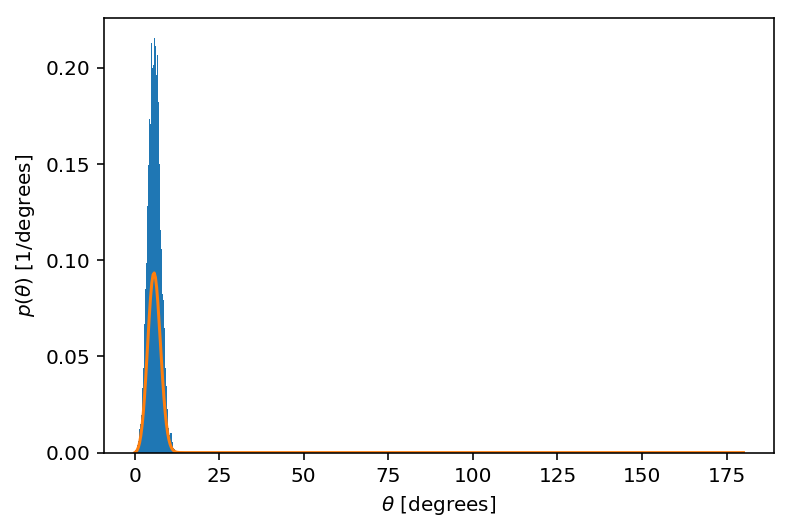

In [12]:
fig, ax = plt.subplots(nrows=1)

ax.hist(theta_samples, bins=50, density=True)
ax.plot(dis, p_is);
ax.set_xlabel(r"$\theta$ [degrees]");
ax.set_ylabel(r"$p(\theta)$ [1/degrees]");

Great, they match up except for some normalization. This is because the actual $p(\theta)$ was unnormalized, and so that's why it appears off. The beauty of rejection sampling is that we never need to compute this normalization factor in order to generate samples from the distribution. 

If we wanted to be obsessive, we could compute the normalization factor for $p(\theta$) numerically and check that they line up exactly.

In [13]:
from scipy.integrate import quad 

norm = quad(input_prob, 0.0, 180.0)

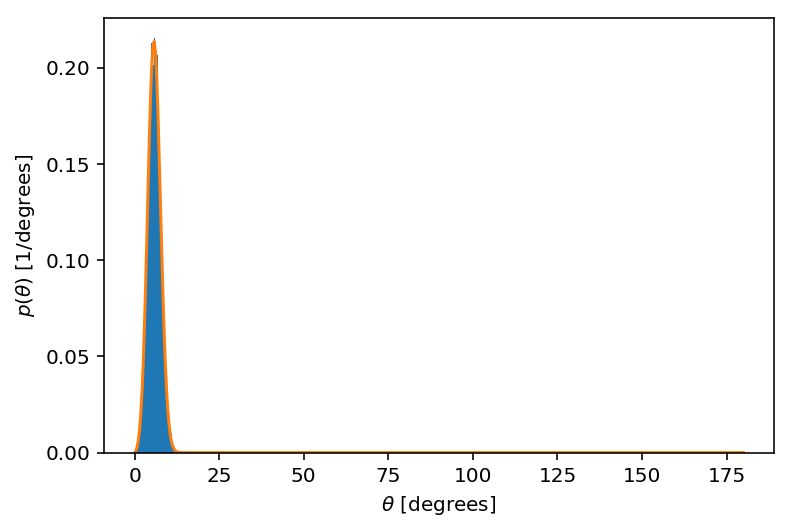

In [14]:
fig, ax = plt.subplots(nrows=1)

ax.hist(theta_samples, bins=50, density=True)
ax.plot(dis, p_is / norm[0]);
ax.set_xlabel(r"$\theta$ [degrees]");
ax.set_ylabel(r"$p(\theta)$ [1/degrees]");

And they do. Now that that's settled, let's create binaries with some degree of misalignment relative to the disk. In the disk frame, we'll set the polar angle ($\theta$) of the binary to be a  mutual inclination chosen from the samples of our mutual inclination distribution, and choose a random direction for the displacement ($\phi$).

In [15]:
thetas = np.random.choice(theta_samples, size=N_systems) # degrees
phis = np.random.uniform(low=0, high=360., size=N_systems) # degrees

In [16]:
# Here are the rotation matrices from before implemented in python

def P_x(xi):
    '''
    Calculate the transformation matrix about the X-axis. Assumes the angle is in degrees.
    '''
    x = xi * deg
    return np.array([[1, 0, 0], [0, np.cos(x), -np.sin(x)], [0, np.sin(x), np.cos(x)]])

def P_z(xi):
    '''
    Calculate the transformation matrix about the Z-axis. Assumes angle is in degrees.
    '''
    x = xi * deg
    return np.array([[np.cos(x), -np.sin(x), 0], [np.sin(x), np.cos(x), 0], [0, 0, 1]])

def get_xyz(theta, phi):
    '''
    Convert angles in the disk frame into x, y, z in the disk frame. All angles in degrees.
    '''
    return np.array([np.sin(theta * deg) * np.cos(phi * deg), \
                     np.sin(theta * deg) * np.sin(phi * deg), \
                     np.cos(theta * deg)])

In [17]:
def get_binary_parameters(i_disk, Omega_disk, theta, phi):
    '''
    Using the matrix math above, calculate i_star and Omega_star. Assumes all angles are in degrees.
    '''
    
    xyz = get_xyz(theta, phi)
    
    res = np.dot(P_z(-Omega_disk).T, np.dot(P_x(i_disk).T, xyz))
    
    X, Y, Z = res 
    
    i_star = np.arccos(Z)/deg
    Omega_star = np.arctan2(Y, X)/deg - 90.0 
    # the -90 is because the projection of the angular momentum vector on the X-Y plane
    # is not the same as the ascending node. There is a 90 degree offset between the two.
    
    return i_star, Omega_star

In [18]:
i_stars_low = np.empty(N_systems, np.float64) # degrees
Omega_stars_low = np.empty(N_systems, np.float64) # degrees

for i in range(N_systems):
    i_stars_low[i], Omega_stars_low[i] = get_binary_parameters(i_disks[i], Omega_disks[i], thetas[i], phis[i]);

In [19]:
thetas_low = calc_theta(i_disks, Omega_disks, i_stars_low, Omega_stars_low)

In [41]:
# compute the mutual inclination of these too, and add it as a column
# for fun, also store the phi column, since our posterior will have it
low_sample = Table([i_disks, Omega_disks, i_stars_low, Omega_stars_low, thetas_low, phis], \
                   names=["i_disk", "Omega_disk", "i_star", "Omega_star", "theta", "phi"])

In [42]:
low_sample

i_disk,Omega_disk,i_star,Omega_star,theta,phi
float64,float64,float64,float64,float64,float64
163.50227502309326,134.8344427850505,166.72348570690102,-203.87113959828403,6.296560867687627,139.50228000148766
19.978699877320064,342.2571503075698,23.61733517749583,-19.215693262447715,3.6792372589288522,80.7659278657986
48.32647488671633,263.51781905210584,52.54333096597094,-102.2985162767618,6.152385500656775,41.35693736480752
125.12216966480769,215.51705431093316,123.86537908300238,-139.54718961925775,4.257132218562629,195.75975315683075
129.52018838155797,56.16671055927715,135.6204907668922,55.895693756662695,6.103555699996742,88.21697848337459
129.28594162348503,56.158027321032954,130.8201796371764,62.14302466876171,4.830066806223517,159.57374843692256
113.04883202952833,20.910100380551807,111.87010181695231,17.076440056302843,3.7336350835334926,342.33676311000835
87.16196151047119,311.82341247897665,84.87470750586259,-46.45038703333929,2.862958491835253,233.0805785353272
97.82280854361962,216.4014042275552,93.60614608671135,-149.14451492031438,6.943927156086379,322.92033430338057


In [22]:
# just to check we've done everything correctly with the right mutual inclinations
np.allclose(thetas, low_sample["theta"])

True

In comparison to the random isotropic sample, we see that nearly all of the systems in the low mutual inclination sample have $i_\mathrm{disk} \approx i_\star$, and indeed, they have low $\theta$ as well.

## The hierarchical model

Now that we have our fake datesets, let's code up our hierarchical model in PyMC3. We'll use only the values for $i_\mathrm{disk}$ and $i_\star$ to infer the mutual inclination distributions for each sample.

In [23]:
# we'll assume that the uncertainties on the fake data are a degree for both the disk and the binary
sd_disk_iso = np.sin(iso_sample["i_disk"].data * deg) * 1.0 * deg
sd_star_iso = np.sin(iso_sample["i_star"].data * deg) * 1.0 * deg

In [24]:
# instantiate a PyMC3 model class 
with pm.Model() as iso_model:
    
    # Technically because the hyperparameters of the Beta distribution are parameters in the model,
    # we also have priors on these values, called hyperpriors. 
    # For now, we'll just asssume a uniform range over the values we plotted up earlier.
    # We'll come back with something more intelligent later.
    # These specify that alpha and beta are random variables to be drawn from a uniform distribution.
    alpha = pm.Uniform("alpha", lower=1.0, upper=100.0)
    beta = pm.Uniform("beta", lower=1.0, upper=100.0)
    
    # The Beta distribution described by these parameters (p_\Beta) will be used for all systems in the sample
    
    # Now, we consider the parameters for individual systems
    # The mutual inclination for any particular system is drawn from the distribution set by these parameters.
    # But, see how the distribution is set by the random variables alpha and beta? 
    # From this distribution, we draw one intermediate mutual inclination variable x for each system
    x = pm.Beta("x", alpha=alpha, beta=beta, shape=N_systems)    

    # Convert from the intermediate variable to the actual mutual inclination angle we want
    cos_theta = pm.Deterministic("cos_theta", 1 - 2 * x)
    
    # Enforce the geometrical prior on i_disk, as before
    cos_i_disk = pm.Uniform("cosIdisk", lower=-1.0, upper=1.0, shape=N_systems, testval=np.cos(iso_sample["i_disk"].data * deg)) 
    
    # This is the azimuthal orientation of the binary vector on the circle some theta away 
    phi = pm.Uniform("phi", lower=-np.pi/2.0, upper=np.pi/2.0, shape=N_systems)

    # Now, we will use cos_i_disk, Delta_I, and phi to calculate cos_i_star
    sin_i_disk = tt.sqrt(1.0 - cos_i_disk**2)
    sin_theta = tt.sqrt(1.0 - cos_theta**2)
    
    cos_i_star = pm.Deterministic("cos_i_star", -sin_i_disk * sin_theta * tt.sin(phi) + \
                                  cos_i_disk * cos_theta)
    
    # Finally, we define the likelihood by conditioning on the observations using a Normal
    obs_disk = pm.Normal("obs_disk", mu=cos_i_disk, sd=sd_disk_iso, observed=np.cos(iso_sample["i_disk"].data * deg))
    obs_star = pm.Normal("obs_star", mu=cos_i_star, sd=sd_star_iso, observed=np.cos(iso_sample["i_star"].data * deg))

For those of you familiar with probabilistic graphical models, this the following diagram is a very nice way to visualize how probability flows from the observations to constrain the model parameters.

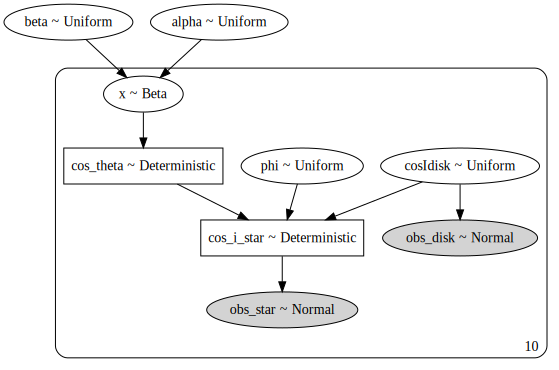

In [25]:
pm.model_to_graphviz(iso_model)

In [26]:
# sample the model!
with iso_model:
    iso_trace = pm.sample(draws=1000, tune=10000, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [phi, cosIdisk, x, beta, alpha]
Sampling 2 chains: 100%|██████████| 22000/22000 [01:37<00:00, 226.68draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


In [27]:
pm.summary(iso_trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,67.674398,23.117589,0.942013,24.621054,99.968763,334.485774,1.003885
beta,27.088436,11.431753,0.618031,3.627456,46.891391,182.404235,1.003826
x__0,0.701217,0.045089,0.001848,0.608191,0.759781,453.193244,0.999802
x__1,0.731945,0.051501,0.002899,0.658267,0.831726,189.709473,0.999597
x__2,0.714651,0.071016,0.003932,0.592390,0.840411,199.035192,1.000012
x__3,0.713903,0.073928,0.003948,0.572122,0.849674,228.729646,0.999530
x__4,0.723363,0.059959,0.003446,0.640551,0.837449,184.288997,1.000322
x__5,0.720792,0.072597,0.003925,0.571606,0.858188,207.008585,1.002400
x__6,0.726323,0.068030,0.003349,0.605248,0.850848,263.483700,1.001688
x__7,0.723722,0.065276,0.003287,0.600017,0.824603,250.256998,0.999703


/Users/ianczekala/.build/miniconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


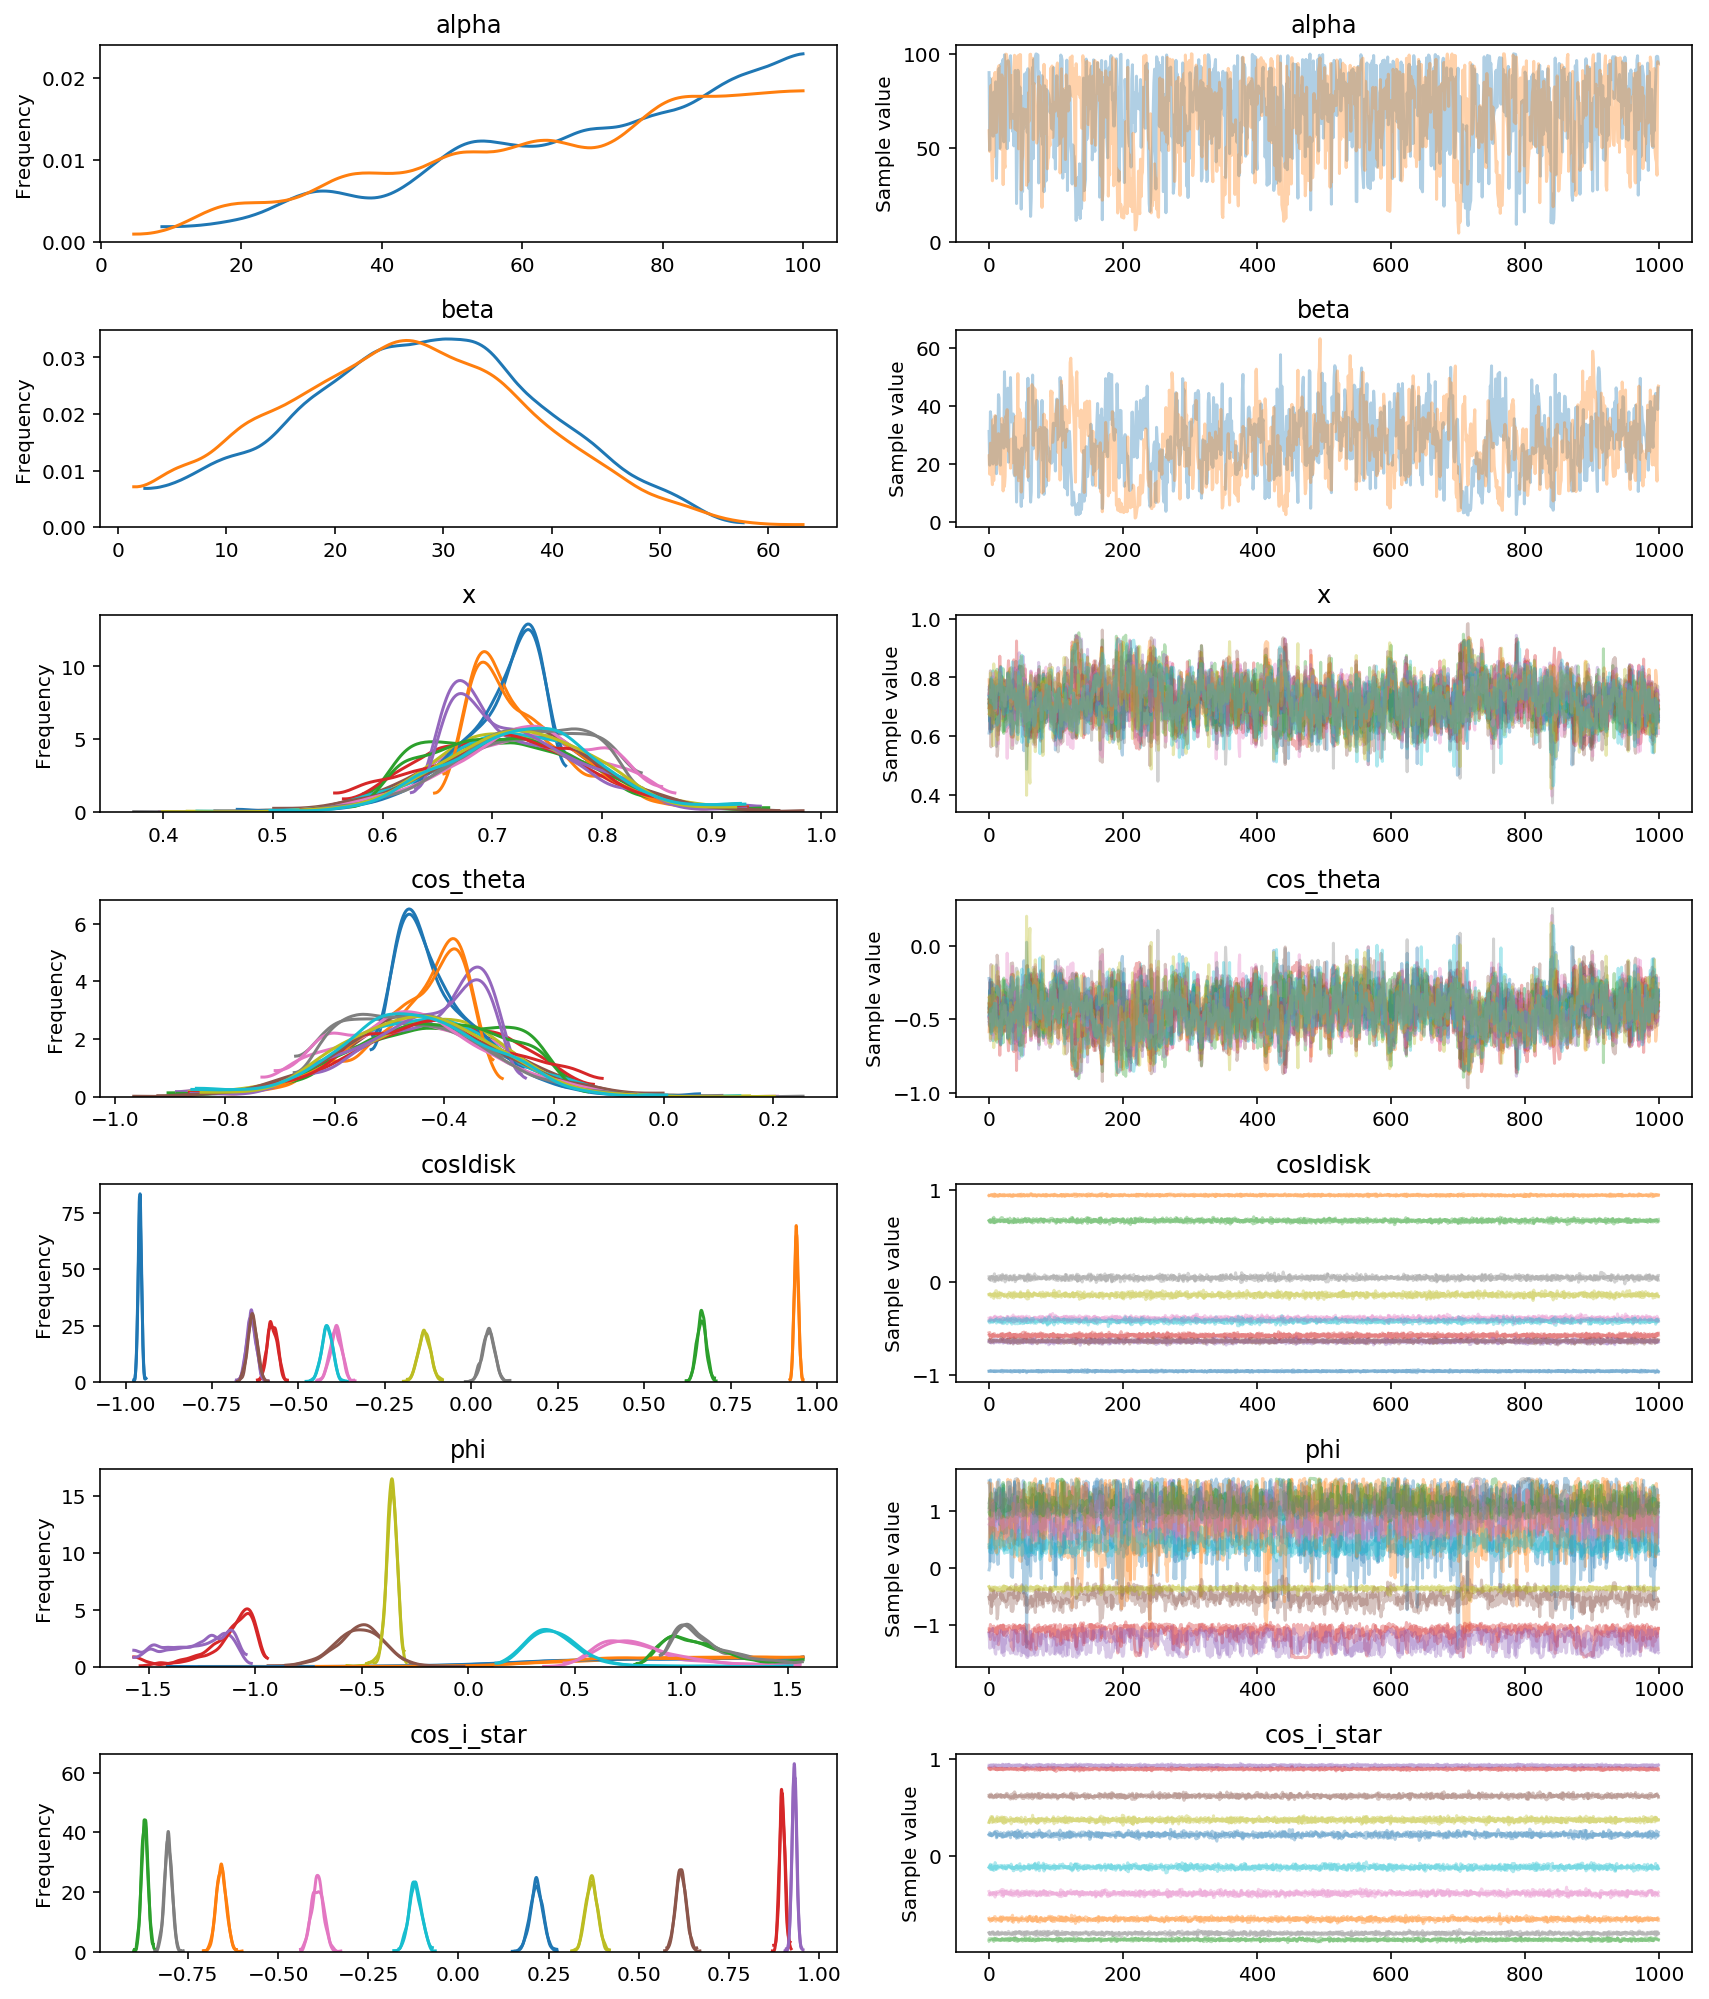

In [28]:
pm.traceplot(iso_trace);

## Examining the posterior

* Plot up the mutual inclination distribution vs. the random distribution (sample many)
* Convert $\cos \theta$ into $\theta$ and compare to the actual values (truths)
* Determine how to calculate $\phi$ for fake disk sample and check this as well.

We can do the same for the sample with low mutual inclinations.

In [29]:
# we'll assume that the uncertainties on the fake data are a degree for both the disk and the binary
sd_disk_low = np.sin(low_sample["i_disk"].data * deg) * 1.0 * deg
sd_star_low = np.sin(low_sample["i_star"].data * deg) * 1.0 * deg

In [97]:
# instantiate a PyMC3 model class 
with pm.Model() as low_model:
    
    # Technically because the hyperparameters of the Beta distribution are parameters in the model,
    # we also have priors on these values, called hyperpriors. 
    # For now, we'll just asssume a uniform range over the values we plotted up earlier.
    # We'll come back with something more intelligent later.
    # These specify that alpha and beta are random variables to be drawn from a uniform distribution.
#     alpha = pm.Uniform("alpha", lower=1.0, upper=1000.0)
#     beta = pm.Uniform("beta", lower=1.0, upper=1000.0)

    log_alpha = pm.Uniform("log_alpha", lower=0.0, upper=4.0)
    log_beta = pm.Uniform("log_beta", lower=0.0, upper=4.0)

    # The Beta distribution described by these parameters (p_\Beta) will be used for all systems in the sample
    
    # Now, we consider the parameters for individual systems
    # The mutual inclination for any particular system is drawn from the distribution set by these parameters.
    # But, see how the distribution is set by the random variables alpha and beta? 
    # From this distribution, we draw one intermediate mutual inclination variable x for each system
    x = pm.Beta("x", alpha=10**log_alpha, beta=10**log_beta, shape=N_systems)    

    # Convert from the intermediate variable to the actual mutual inclination angle we want
    cos_theta = pm.Deterministic("cos_theta", 1 - 2 * x)
    
    # Enforce the geometrical prior on i_disk, as before
    # Testval tells the chain to start in the center of the posterior.
    cos_i_disk = pm.Uniform("cosIdisk", lower=-1.0, upper=1.0, shape=N_systems, testval=np.cos(low_sample["i_disk"].data * deg)) 
    
    # This is the azimuthal orientation of the binary vector on the circle some theta away 
    phi = pm.Uniform("phi", lower=-np.pi/2.0, upper=np.pi/2.0, shape=N_systems)

    # Now, we will use cos_i_disk, Delta_I, and phi to calculate cos_i_star
    sin_i_disk = tt.sqrt(1.0 - cos_i_disk**2)
    sin_theta = tt.sqrt(1.0 - cos_theta**2)
    
    cos_i_star = pm.Deterministic("cos_i_star", -sin_i_disk * sin_theta * tt.sin(phi) + \
                                  cos_i_disk * cos_theta)
    
    # Finally, we define the likelihood by conditioning on the observations using a Normal
    obs_disk = pm.Normal("obs_disk", mu=cos_i_disk, sd=sd_disk_low, observed=np.cos(low_sample["i_disk"].data * deg))
    obs_star = pm.Normal("obs_star", mu=cos_i_star, sd=sd_star_low, observed=np.cos(low_sample["i_star"].data * deg))

In [98]:
# sample the model!
with low_model:
    low_trace = pm.sample(draws=5000, tune=40000, chains=2, nuts_kwargs={"target_accept":0.95})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [phi, cosIdisk, x, log_beta, log_alpha]
Sampling 2 chains: 100%|██████████| 22000/22000 [02:02<00:00, 179.44draws/s]
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [93]:
low_trace

<MultiTrace: 2 chains, 5000 iterations, 12 variables>

In the space of $\theta$, this prior is 

$$
p_k(\theta) = p_k(x_k| \alpha, \beta) \frac{\mathrm{d}x}{\mathrm{d}\theta} = 0.5 p_\beta(0.5(1 - \cos \theta) | \alpha, \beta) \sin(\theta)
$$

(0, 25)

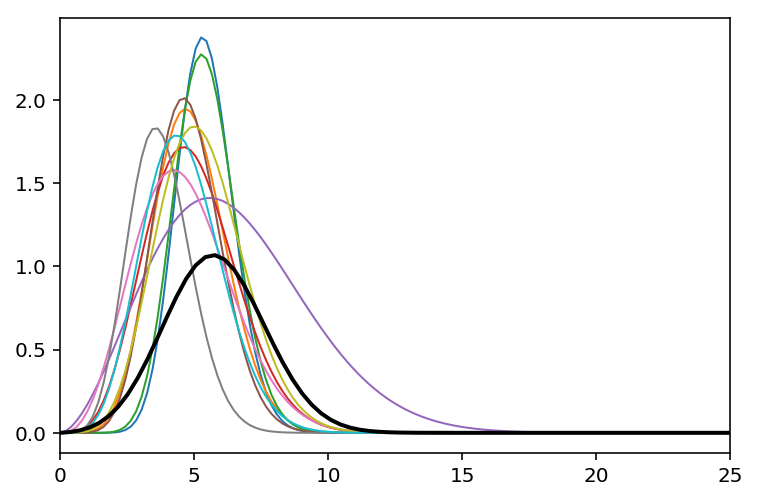

In [106]:
N_realizations = 10

N_samples = len(low_trace)
ind = np.random.choice(range(N_samples), size=N_realizations)
alphas = 10**low_trace["log_alpha"][ind]
betas =  10**low_trace["log_beta"][ind]

thetas = np.linspace(0, 20, num=100)
xs = 0.5 * (1.0 - np.cos(thetas * deg))

fig, ax = plt.subplots(nrows=1)

for (alpha, beta) in zip(alphas, betas):
    y = pm.Beta.dist(alpha=alpha, beta=beta) # query the PyMC3 implementation
    ys = np.exp(0.5 * np.array([y.logp(x).eval() for x in xs])) * np.sin(thetas * deg)

#     ax.plot(xs, ys)
    ax.plot(thetas, ys, lw=1.0)
    
# plot the actual distribution as a dotted black line
ax.plot(dis, p_is/norm[0] * 5, color="k", lw=2.0);
ax.set_xlim(0, 25)

# y = pm.Beta.dist(alpha=1.1, beta=500) # query the PyMC3 implementation
# ys = np.exp(0.5 * np.array([y.logp(x).eval() for x in xs])) * np.sin(thetas * deg)

#     ax.plot(xs, ys)
# ax.plot(thetas, ys, lw=3.0, color="k")


In [ ]:
def explore_trace(htrace):
    '''Make some diagnostic plots of the samples of the hierarcical model
    
    1. return samples of p(theta)
    2. make plots of pameters for individual disks, and compare with truth values
    
    '''
    
    

In [94]:
pm.summary(low_trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,0.164012,0.124357,0.002272,2.688619e-05,0.405133,3075.746544,0.999964
beta,2.818596,0.154593,0.002116,2.509510e+00,2.999947,5442.697732,0.999909
x__0,0.002025,0.001905,0.000022,2.245918e-06,0.005463,6764.169737,1.000031
x__1,0.002108,0.001761,0.000025,2.707550e-05,0.005323,5416.059630,0.999938
x__2,0.002321,0.001790,0.000022,9.804697e-05,0.005632,5818.507425,0.999900
x__3,0.001634,0.001812,0.000027,6.982648e-07,0.005141,4818.839694,0.999947
x__4,0.003293,0.001923,0.000029,4.085530e-04,0.006752,4794.241159,1.000149
x__5,0.001677,0.001828,0.000028,6.091110e-07,0.005006,4959.977243,0.999922
x__6,0.001612,0.001766,0.000024,6.415158e-07,0.005056,4961.106138,0.999913
x__7,0.001793,0.001802,0.000026,1.698072e-06,0.005304,4409.944596,1.000000


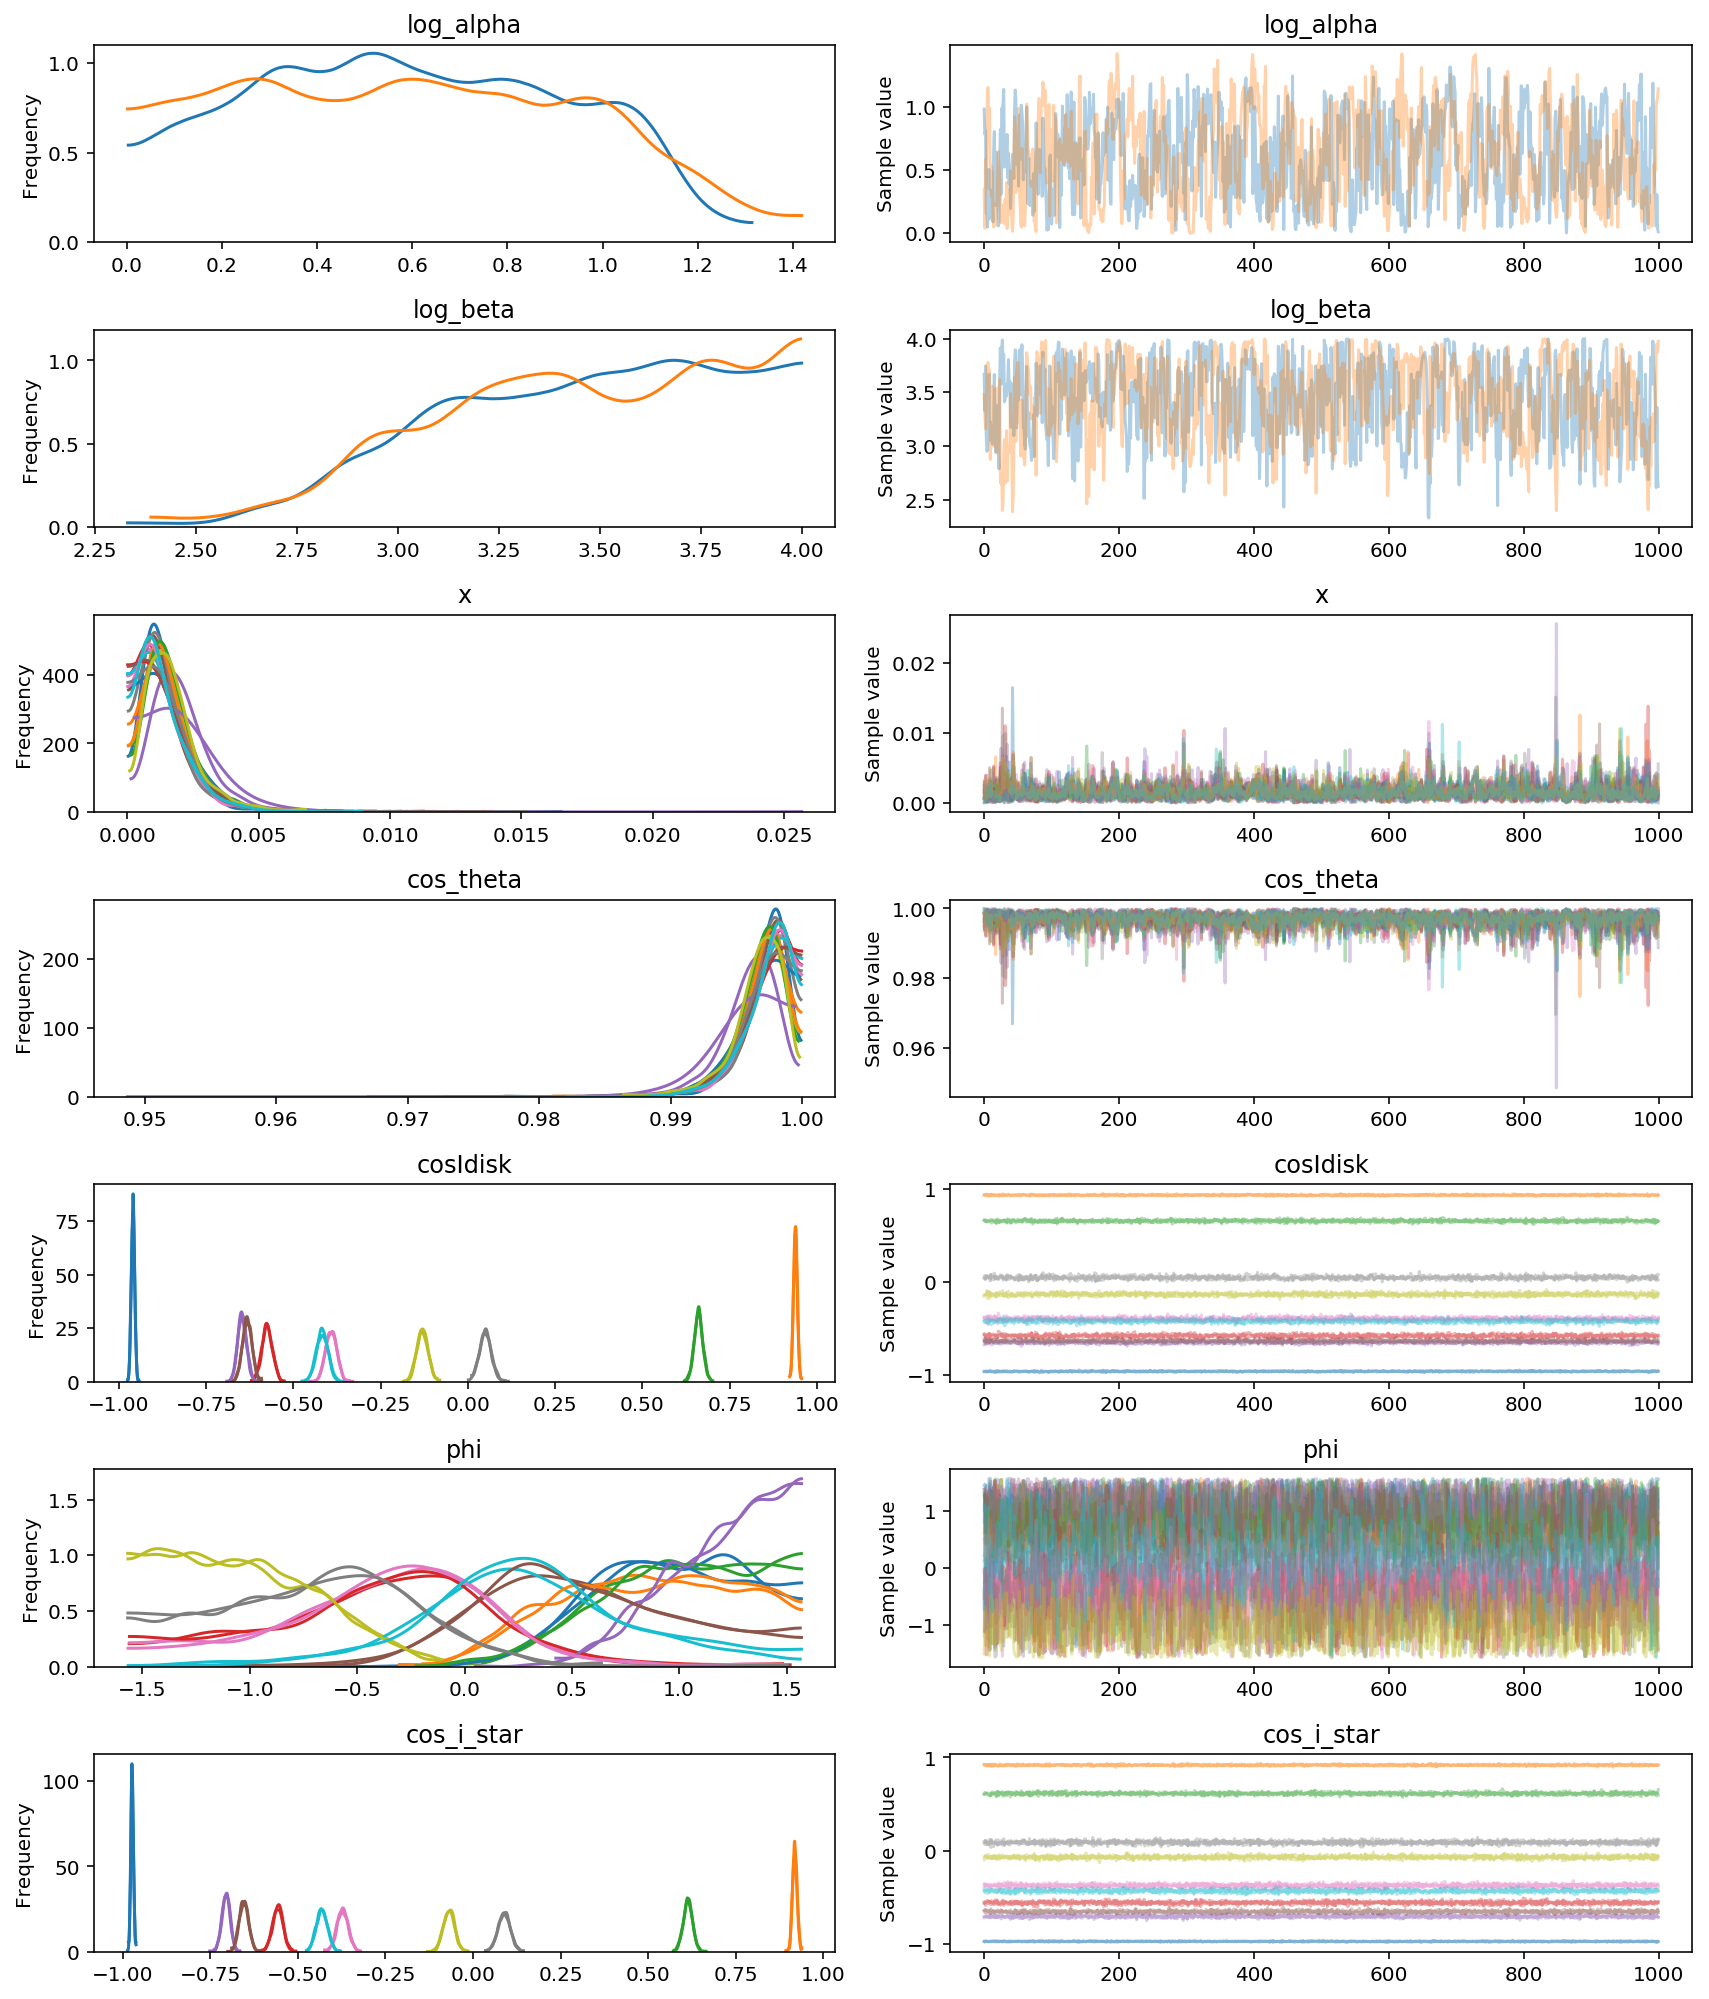

In [101]:
pm.traceplot(low_trace);

[139.50228     80.76592787  41.35693736 195.75975316  88.21697848
 159.57374844 342.33676311 233.08057854 322.9203343  167.11159161]
        phi        
-------------------
  40.49771999851234
   80.7659278657986
  41.35693736480752
-15.759753156830755
  88.21697848337459
 20.426251563077443
  17.66323688999165
 -53.08057853532719
  37.07966569661943
 12.888408391700523


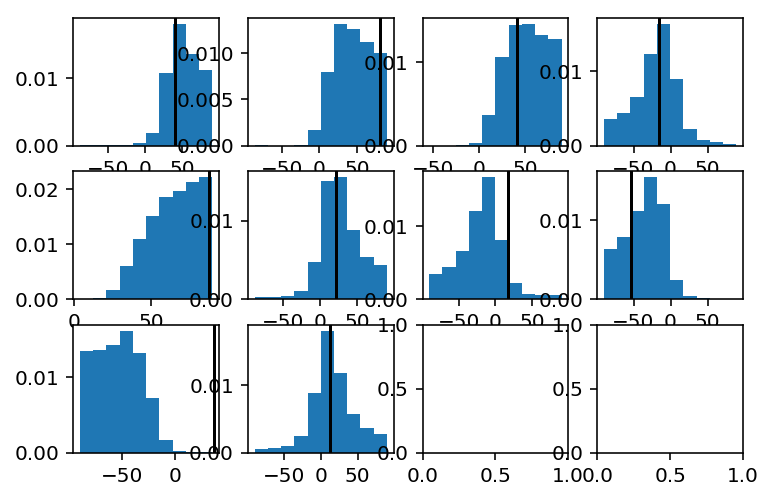

In [90]:
fig, ax = plt.subplots(nrows=3, ncols=4)

phi_samples = low_trace["phi"] / deg

print(phis)
# put this in the range - pi/2 to pi/2 
phi_data = low_sample["phi"] 
print(phi_data)
phi_data[phi_data > 90] = 180 - phi_data[phi_data > 90] 
phi_data[phi_data < -90] = 180 + phi_data[phi_data < -90]
    
for i, a in enumerate(ax.flatten()):
    if i < N_systems:
        a.hist(phi_samples[:,i], density=True)
        a.axvline(phi_data[i], color="k")

# Improvements

- analytically marginalize over $\phi$
- use a better prior on the $\beta$ distribution hyperparameters
- see what happens if we erroneously measure retrograde binary orbits as prograde